In [2]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt
import os


from pyspecter.SPECTER import SPECTER
from pyspecter.Observables import Observable
# from pyspecter.SpecialObservables import SpecialObservables

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import newplot
from pyshaper.utils.plot_utils import plot_event

# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
from pyspecter.SpectralEMD_Helper import compute_spectral_representation

2024-03-06 17:12:46.853340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


# Dataset

In [7]:
# Parameters 
R = 1
this_dir = ""
this_study = "cmsopendata"
sprongs = 3

dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 10000)
triangle_events, triangle_indices = load_triangles(180, 180, R = 1.0, return_indices=True)

dataset = dataset_open

Max # of particles: 132


# Construct Train Step for N-Subjettiness

In [3]:
# Initializer
# import fastjet._pyjet  # noqa: F401

# from fastjet._pyjet import ClusterSequence, JetDefinition, PseudoJet

# import pyfjcore

from pyjet import cluster

def kT_N(events, N, R):

    jets = []

    for event in events:

        # Set up 4-vectors
        four_vectors = []
        for particle in event:
            four_vectors.append((particle[0], particle[1], particle[2], 0))
        four_vectors = np.array(four_vectors, dtype=[("pt", "f8"), ("eta", "f8"), ("phi", "f8"), ("mass", "f8")])

        # Cluster with kT (p = 1)
        sequence = cluster(four_vectors, R=R, p=1)
        subjets = sequence.exclusive_jets(N)

        output = np.zeros((N, 3))
        for i, subjet in enumerate(subjets):
            output[i,0] = subjet.pt
            output[i,1] = subjet.eta
            output[i,2] = subjet.phi


        # Normalize
        output[:,0] = np.nan_to_num(output[:,0] / np.sum(output[:,0]))

        jets.append(output)


    return np.array(jets)


In [4]:
from pyspecter.SpectralEMD_Helper import ds2_events1_spectral2
import jax.example_libraries.optimizers as jax_opt
from jax.example_libraries import optimizers
import jax
import tqdm


# Gradients
vmap_compute_spectral_representation = jax.vmap(compute_spectral_representation, in_axes = 0)
vmap_ds2_events1_spectral2 = jax.vmap(ds2_events1_spectral2)
ds2_events1_spectral2_gradients = grad(ds2_events1_spectral2, )
vmap_ds2_events1_spectral2_gradients = jax.vmap(ds2_events1_spectral2_gradients)


# Function to enforce normalization of energies
def project(events):

    temp = jnp.copy(events)
    zs = events[:,:,0]
    num_particles = events.shape[1]
    batch_size = events.shape[0]

    cnt_n = jnp.arange(num_particles)
    cnt_i = jnp.arange(batch_size)

    u = jnp.sort(zs, axis = -1)[:,::-1]
    v = (jnp.cumsum(u, axis = -1)-1) / (cnt_n + 1)
    w = v[cnt_i, jnp.sum(u > v, axis = -1) - 1]
    temp2 = temp.at[:,:,0].set(jnp.maximum(zs - w[:,None], 0))

    # temp = temp.at[:,:,0].set(jnp.maximum(temp[:,:,0], 0))
    # return temp

    return temp2

# For N-spronginess, the shape is just the params
def shape_from_params(params):
    return params


def initialize(events, N, seed):

    # new_events = jnp.ones((events.shape[0], N, 3)) / N
    # new_events = new_events.at[:,:,1:3].set(R/4 * jax.random.normal(seed, (N, 2)))
    # # new_events = new_events.at[:,0,1:3].set( (0,.000))
    # # new_events = new_events.at[:,1,1:3].set( (1,0))


    return kT_N(events, N, R)

def compute_N_spronginess(events, N, epochs = 100, learning_rate = 1e-2):
    
    # Get spectral representation of events:
    events_spectral = vmap_compute_spectral_representation(events)

    # Initialize events
    shape_events = initialize(events, N, seed = random.PRNGKey(0))

    
    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(learning_rate)
    opt_state = opt_init(shape_events)

    losses = np.zeros((epochs, events.shape[0]))


    for epoch in tqdm.tqdm(range(epochs)):


        params = get_params(opt_state)
        shape_events = shape_from_params(params)
        shape_events = project(shape_events)
        sEMDs, grads = train_step(epoch, events_spectral, shape_events)
        opt_state = opt_update(epoch, grads, opt_state)

       # Apply the separate function to modify the parameters
        new_params = project(get_params(opt_state))

        # Manually modify the opt_state's parameters without resetting internal state
        opt_state = replace_params_in_state(opt_state, new_params)
        losses[epoch] = sEMDs
        


    return jnp.min(losses, axis = 0), shape_events, losses

def replace_params_in_state(opt_state, new_params):
    if isinstance(opt_state, tuple) and len(opt_state) == 2 and isinstance(opt_state[0], dict):
        # This is the parameter tuple for Adam
        return (new_params, opt_state[1])
    elif isinstance(opt_state, tuple):
        # Unpack and modify recursively
        return tuple(replace_params_in_state(sub_state, new_params) for sub_state in opt_state)
    else:
        # Leaf node or unknown type, return unchanged
        return opt_state

@jax.jit
def train_step(epoch, spectral_events, shape_events):

    sEMDS = vmap_ds2_events1_spectral2(shape_events, spectral_events)
    grads = vmap_ds2_events1_spectral2_gradients(shape_events, spectral_events)
    return sEMDS, jnp.nan_to_num(grads)




In [5]:
# sprongs = 2
sEMDs, shape_events, losses = compute_N_spronginess(dataset, sprongs, epochs = 500, learning_rate = 5e-2)

filename = f"{this_study}_{sprongs}_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, sEMDs)


# plot the average loss per epoch
plt.plot(np.mean(losses, axis = -1))
# plt.yscale("log")

  3%|▎         | 14/500 [00:43<24:36,  3.04s/it]

In [ ]:
print(np.where(sEMDs < 0))

# print(shape_events[46])np.where(losses < 0)
print(project(np.array([shape_events[46],])))

(array([], dtype=int64),)
[[[ 0.08090981  0.08465032 -0.10943121]
  [ 0.01083799  0.38657117 -0.10806435]
  [ 0.9082522   0.02246826 -0.11130536]]]


# Closed Form Expressions

In [ ]:
def theta(x):
    return x > 0


def find_omega12(spectral_events, two_E1E2):

    omega = spectral_events[:,0]
    two_EE = spectral_events[:,1]



    cumulative = jnp.cumsum(spectral_events[:,1], axis = -1)
    cumulative_exclusive = cumulative - spectral_events[:,1]
    total_energy = cumulative[-1]

    term1 = (two_EE) / two_E1E2
    theta1 = theta(two_E1E2 - total_energy + cumulative_exclusive)

    term2 = 1 - (total_energy - cumulative) / two_E1E2
    theta2a = 1 - theta1
    theta2b = theta(two_E1E2 - total_energy + cumulative)
    theta2 = theta2a * theta2b

    total = jnp.sum(omega * (term1 * theta1 + term2 * theta2), axis = -1)
    return total

vmap_find_omega12 = jax.vmap(jax.jit(find_omega12), in_axes = (0, None))

def closed_form_2_spronginess(events, levels = 50):

    two_E1E2 = np.linspace(0.0001, 1/2, levels)
    sEMDs = np.zeros((levels, events.shape[0]))

    spectral_events = vmap_compute_spectral_representation(events)


    for i in tqdm.tqdm(range(levels)):
        find_omega12 = vmap_find_omega12(spectral_events, two_E1E2[i])
        term_1 = np.sum(spectral_events[:,:,0]**2 * spectral_events[:,:,1] , axis = -1)
        term_2 = two_E1E2[i] * find_omega12**2

        sEMDs[i] = term_1 - term_2

    # Take the minimum over all levels
    return np.min(sEMDs, axis = 0)





In [ ]:
closed_form_sEMDs = closed_form_2_spronginess(dataset, levels = 150)
print(closed_form_sEMDs)


filename = f"{this_study}_{sprongs}_closed_form_sEMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, closed_form_sEMDs)

100%|██████████| 150/150 [01:08<00:00,  2.19it/s]

[0.00827267 0.00511824 0.00759102 ... 0.00417313 0.00342417 0.0030494 ]


# SHAPER

Using CPU!
Batch 0 of 10
Observable: 3-Subjettiness Epoch 0 Mean Loss = 0.0022042573294529574 Elapsed time = 1.902s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 1 Mean Loss = 0.0022743154317577136 Elapsed time = 3.825s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 2 Mean Loss = 0.0022246475619031114 Elapsed time = 5.727s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 3 Mean Loss = 0.0022263728072939555 Elapsed time = 7.701s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 4 Mean Loss = 0.0022400329222873553 Elapsed time = 9.630s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 5 Mean Loss = 0.002230009014630923 Elapsed time = 11.564s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 6 Mean Loss = 0.0022141830569453306 Elapsed time = 13.478s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 7 Mean Loss = 0.0022099882246620836 Elapsed time = 15.390s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 8 Mean Loss 

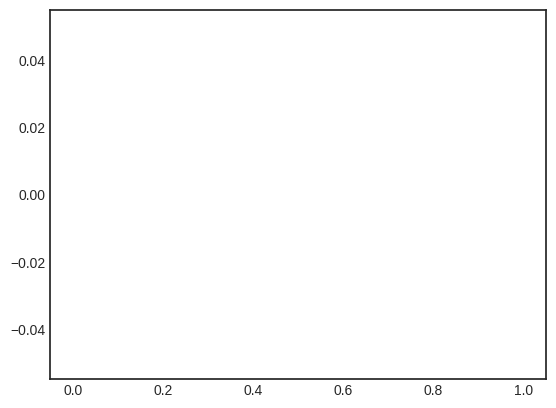

In [8]:
# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 


# Generate new events

R = 1.0
N = 180
angles = np.linspace(0, np.pi, N)
energies = np.linspace(0, 1, N)

events = []
for i in range(dataset.shape[0]):

    event = dataset[i]

    zs = event[:,0]
    points = event[:,1:3]

    events.append((points, zs))


# EMDs

commonObservables, pointers = buildCommmonObservables(N = 3, beta = 2, R = R, device = device)
_2subjettiness = commonObservables[f"{sprongs}-Subjettiness"]


# Collect our observables in one dictionary
observables = {}
observables[f"{sprongs}-Subjettiness"] = _2subjettiness

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


EMDs = []
params = []


batch_size = 1000

for i in range(0, len(events), batch_size):
    print("Batch", i, "of", len(events) // batch_size)
    dataset_emds, dataset_params = shaper.calculate(dataset[i:i+batch_size], epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)
    for j in range(dataset_emds[f"{sprongs}-Subjettiness"].shape[0]):
        e = dataset_params[f"{sprongs}-Subjettiness"][j]["EMD"]
        EMDs.append(e)

        # points = dataset_params[f"{sprongs}-Subjettiness"][j]["Points"]
        # distance = np.linalg.norm(points[0] - points[1])

        # params.append(distance)




EMDs = np.array(EMDs)
params = np.array(params)


plt.hist(params)
print(np.mean(params))

filename = f"{this_study}_{sprongs}_shaper_EMDs.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, EMDs)

filename = f"{this_study}_{sprongs}_shaper_params.npy"
save_dir = os.path.join(this_dir, filename)
np.save(save_dir, params)

# Plots

348


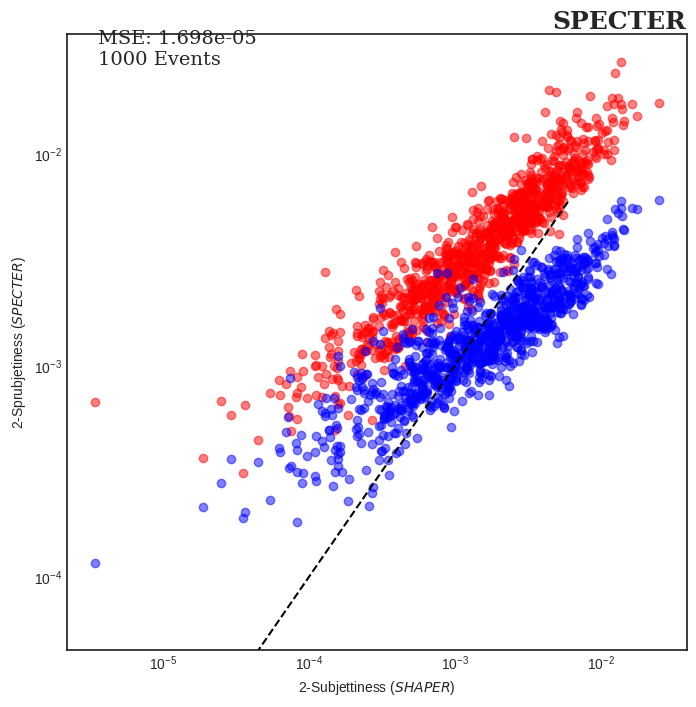

In [ ]:
fig, ax = newplot()

# Load numpy data
sEMDs = np.load(os.path.join(this_dir, f"{this_study}_sEMDs.npy"))
closed_form_sEMDs = np.load(os.path.join(this_dir, f"{this_study}_closed_form_sEMDs.npy"))
EMDs = np.load(os.path.join(this_dir, f"{this_study}_shaper_EMDs.npy"))


plt.scatter(2 * EMDs**2, closed_form_sEMDs, color = "red", alpha = 0.5)
plt.scatter(2 * EMDs**2,  sEMDs, color = "blue", alpha = 0.5)



plt.xscale("log")
plt.yscale("log")
plt.xlabel("2-Subjettiness ($SHAPER$)")
plt.ylabel("2-Sprubjetiness ($SPECTER$)")

# Dashed line at y = x
x = np.linspace(0, np.max(sEMDs), 100)
plt.plot(x, x, linestyle = "--", color = "black")

# print the MSE in the top left
mse = np.mean((np.maximum(sEMDs, 0) - closed_form_sEMDs)**2)
plt.text(0.05, 0.95, "MSE: %.3e\n1000 Events" % mse, transform=ax.transAxes, fontsize=14,)

# print the percentage of events that differ by more than temp1%
diff = (sEMDs - (2 * EMDs**2)) / (2 * EMDs**2)
print(np.sum(diff > 0.10))
# plt.scatter(np.maximum(sEMDs, 0)[diff > 0.10], closed_form_sEMDs[diff > 0.10])

# ax.set_aspect('equal')

Text(0.5, 0, 'Fractional Error')

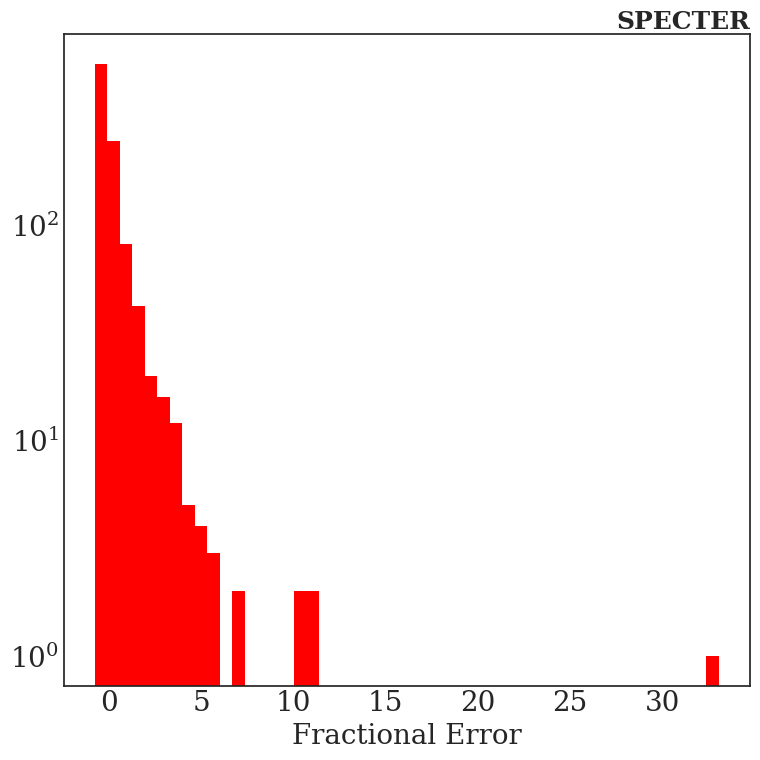

In [ ]:
# Plot a histogram of the differences
fig, ax = newplot()
plt.hist(diff, bins = 50 )

# plt.xscale("log")
plt.yscale("log")

plt.xlabel("Fractional Error")
